# DDIM Inpainting on MNIST
**Learning:** Build a DDIM pipeline for center-hole inpainting: timestep-conditioned U-Net, DDIM sampling, hole-only PSNR/L1.  
**Goal:** Train on masked MNIST, then sample reconstructions and evaluate only inside the mask.  
> **Tip:** Use **Google Colab (GPU)** and keep batch size modest to avoid OOM.


## 0. Prerequisites (Colab GPU)
- In Colab: **Runtime → Change runtime type → Hardware accelerator → GPU → Save**.
- CPU works but training will be **much slower**.
- This notebook installs only minimal packages.

> If you prefer Kaggle: enable GPU in **Settings → Accelerator → GPU**.

**Quick GPU check (run once):**
```python
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0))

## 1. Install minimal dependencies

- **Colab users:** PyTorch is already installed—**don’t reinstall `torch`/`torchvision`**. Install only extras below.  
- **Non-Colab users:** Use the pinned install shown after the Colab snippet.

**Colab (recommended):**
```bash
!pip -q install -U tqdm matplotlib


In [1]:
!pip -q install -U tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 144.7 MB/s eta 0:00:00


## 2. Check GPU

Run this cell to verify that CUDA is available (Colab GPU recommended):

```python
import torch, platform
print("Python:", platform.python_version())
print("PyTorch:", torch.__version__)
print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU — training will be much slower.")


In [2]:
import torch, platform
print("Python:", platform.python_version())
print("PyTorch:", torch.__version__)
print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU — training will be much slower.")


Python: 3.12.12
PyTorch: 2.9.0+cu126
CUDA available? True
GPU: NVIDIA A100-SXM4-80GB


## 3. Quick Equations (reference)

**Forward noising**
$$
x_t=\sqrt{\bar{\alpha}_t}\,x_0+\sqrt{1-\bar{\alpha}_t}\,\varepsilon,\qquad \varepsilon\sim\mathcal N(0,I)
$$

**Cosine schedule — beta\_t from abar(t)**
$$
\bar{\alpha}(t)=\cos^2\!\left(\frac{t/T+s}{1+s}\cdot\frac{\pi}{2}\right)
$$
$$
\beta_t=\min\!\left(0.999,\;1-\frac{\bar{\alpha}(t+1)}{\bar{\alpha}(t)}\right)
$$

**Prediction-space mapping**
- **pred = `eps`**
$$
\hat\varepsilon=\text{out},\qquad
\hat x_0=\frac{x_t-\sqrt{1-\bar{\alpha}_t}\,\hat\varepsilon}{\sqrt{\bar{\alpha}_t}}
$$

- **pred = `x0`**
$$
\hat x_0=\text{out},\qquad
\hat\varepsilon=\frac{x_t-\sqrt{\bar{\alpha}_t}\,\hat x_0}{\sqrt{1-\bar{\alpha}_t}}
$$

- **pred = `v`**
$$
\hat x_0=\sqrt{\bar{\alpha}_t}\,x_t-\sqrt{1-\bar{\alpha}_t}\,\text{out},\qquad
\hat\varepsilon=\sqrt{1-\bar{\alpha}_t}\,x_t+\sqrt{\bar{\alpha}_t}\,\text{out}
$$

**DDIM step** (optional noise eta)
$$
\sigma_t=\eta\cdot\sqrt{\frac{1-\bar{\alpha}_{t'}}{1-\bar{\alpha}_t}\left(1-\frac{\bar{\alpha}_t}{\bar{\alpha}_{t'}}\right)}
$$
$$
x_{t'}=\sqrt{\bar{\alpha}_{t'}}\,\hat x_0+\sqrt{1-\bar{\alpha}_{t'}-\sigma_t^{2}}\,\hat\varepsilon+\mathbf{1}_{\eta>0}\,\sigma_t z
$$


## 4. Utilities & Data _(GIVEN — do not modify)_

Helper functions used throughout the notebook:
- **Repro & device:** `seed_all`, `dev`
- **I/O & viz:** `ensure_dir`, `save_grid`, `safe_torch_load`
- **Data:** `get_mnist_loader` (MNIST → 32×32, normalized to \([-1,1]\))
- **Masking:** `make_center_box_mask` (zeros at center box = hole)
- **Metrics (hole-only):** `psnr_on_mask`, `l1_on_mask`

> Note: `seed_all` sets `cudnn.benchmark=True` for speed (slightly non-deterministic). If you need **strict reproducibility**, temporarily set it to `False`.


In [3]:
import os, math, json, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from dataclasses import dataclass
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------
# Utils
# ----------------------------
def seed_all(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

def dev():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def ensure_dir(p):
    os.makedirs(p, exist_ok=True); return p

def save_grid(x, path, nrow=8, rng=(-1,1), dpi=220):
    ensure_dir(os.path.dirname(path) or ".")
    grid = vutils.make_grid(x, nrow=nrow, normalize=True, value_range=rng)
    plt.figure(figsize=(5,5)); plt.axis("off")
    arr = grid.detach().cpu().numpy().transpose(1,2,0)
    if arr.shape[2] == 1:
        arr = np.repeat(arr, 3, axis=2)
    plt.imshow(arr); plt.tight_layout(); plt.savefig(path, dpi=dpi); plt.close()

def safe_torch_load(path, map_location="cpu"):
    try:
        return torch.load(path, map_location=map_location, weights_only=True)  # PyTorch ≥2.4
    except TypeError:
        return torch.load(path, map_location=map_location)

def get_mnist_loader(batch_size=128, num_workers=2):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32,32), antialias=True),
        transforms.Normalize((0.5,), (0.5,)),  # [-1,1]
    ])
    tr = datasets.MNIST('./data', train=True,  transform=tfm, download=True)
    te = datasets.MNIST('./data', train=False, transform=tfm, download=True)
    train = DataLoader(tr, batch_size, shuffle=True,  num_workers=num_workers, drop_last=True)
    test  = DataLoader(te, batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train, test, (1,32,32)

# ----------------------------
# Masks (centered, fixed size)
# ----------------------------
def make_center_box_mask(B, H, W, box=12):
    m = torch.ones(B,1,H,W)
    hs, ws = H//2, W//2
    h0, h1 = hs - box//2, hs + box//2
    w0, w1 = ws - box//2, ws + box//2
    m[:,:,h0:h1,w0:w1] = 0.0
    return m

# ----------------------------
# Metrics (hole region only)
# ----------------------------
@torch.no_grad()
def psnr_on_mask(pred, target, known_mask, eps=1e-8):
    hole = (1.0 - known_mask)
    N = hole.sum().clamp_min(1.0)
    p = (pred+1)/2; t = (target+1)/2
    mse = ((p - t)**2 * hole).sum() / N
    return float(10.0 * torch.log10(1.0 / (mse + eps)))

@torch.no_grad()
def l1_on_mask(pred, target, known_mask):
    hole = (1.0 - known_mask)
    N = hole.sum().clamp_min(1.0)
    return float(((pred - target).abs() * hole).sum() / N)

## 5. Model & Diffusion — YOUR IMPLEMENTATIONS (TODO)

You’ll implement the core pieces of the model and sampler. Keep interfaces unchanged; only fill the **TODO** parts. Use the **Quick Equations** section above as reference.


In [4]:
def sinusoidal_embed(t: torch.Tensor, dim: int) -> torch.Tensor:
    r"""
    ### TODO: implement sinusoidal timestep embedding ϕ(t) ∈ ℝ^{B×dim}.

    Let H = ⌊dim/2⌋, and frequencies
      f_k = exp( - (log 10000) * k / max(1, H-1) ),  k = 0..H-1.

    Define
      ϕ(t) = [ sin(t f_0), ..., sin(t f_{H-1}),  cos(t f_0), ..., cos(t f_{H-1}) ].
    If dim is odd, append one zero column.

    Inputs:
      t: (B,) Long/float tensor (will cast to float internally)
      dim: embedding size
    Output:
      (B, dim) on same device as t.
    """
    # ====== Implement here ======
    device = t.device
    t = t.float()

    half_dim = dim // 2
    if half_dim == 0:
        # degenerate case, just zeros
        return torch.zeros(t.shape[0], dim, device=device)

    # f_k = exp( - (log 10000) * k / max(1, H-1) )
    denom = max(1, half_dim - 1)
    k = torch.arange(half_dim, device=device)
    freqs = torch.exp(-math.log(10000.0) * k / denom)  # (H,)

    # t
    angles = t[:, None] * freqs[None, :]  # (B,H)
    emb = torch.cat([angles.sin(), angles.cos()], dim=-1)  # (B,2H)

    # If dim is odd, pad one column of zeros
    if emb.shape[1] < dim:
        pad = dim - emb.shape[1]
        emb = F.pad(emb, (0, pad))

    return emb

def _make_group_norm(ch: int, groups: int) -> nn.GroupNorm:
    """Helper: choose a divisor of ch up to `groups`."""
    g = groups
    while g > 1 and (ch % g) != 0:
        g -= 1
    return nn.GroupNorm(g, ch)

class ResBlock(nn.Module):
    r"""
    ### TODO: Residual block with time embedding injection

    Given input x ∈ ℝ^{B×C×H×W} and time embedding e ∈ ℝ^{B×E},
    compute:
      h = x + MLP(e)[:, :, None, None]
      h = GN(C) → SiLU → Conv2d(C→C, 3×3, s=1, p=1)
      h = Dropout2d(p=dropout)
      h = GN(C) → SiLU → Conv2d(C→C, 3×3, s=1, p=1)
      out = x + h

    Use GroupNorm with 'groups' (cap to divisors of C; at least 1).
    """
    def __init__(self, ch: int, emb: int, dropout: float=0.1, groups: int=8):
        super().__init__()
        # ====== Implement here ======
        # MLP(e) -> (B, ch)
        self.emb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb, ch)
        )

        # First GN -> SiLU -> Conv
        self.norm1 = _make_group_norm(ch, groups)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=1)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Second GN -> SiLU -> Conv
        self.norm2 = _make_group_norm(ch, groups)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=1)


    def forward(self, x: torch.Tensor, e: torch.Tensor) -> torch.Tensor:
        # ====== Implement here ======
        emb_out = self.emb_proj(e)[:, :, None, None]  # (B,ch,1,1)

        # First block
        h = x + emb_out
        h = self.norm1(h)
        h = self.act1(h)
        h = self.conv1(h)

        # Dropout
        h = self.dropout(h)

        # Second block
        h = self.norm2(h)
        h = self.act2(h)
        h = self.conv2(h)

        # Residual
        return x + h


class SelfAttention2d(nn.Module):
    r"""
    ### TODO: Single-head self-attention at spatial resolution (e.g., 8×8).

    Normalize with GroupNorm(8, C).
    Compute q,k,v via 1×1 convs (C→C).
    Shapes:
      x: (B,C,H,W)
      q: (B,HW,C)   from (B,C,H,W) → (B,C,HW) → (B,HW,C)
      k: (B,C,HW)
      v: (B,HW,C)
      attn = softmax( (q @ k)/√C , dim=-1 )   → (B,HW,HW)
      out  = (attn @ v) → (B,HW,C) → (B,C,H,W) → proj 1×1 → residual add.
    """
    def __init__(self, ch: int):
        super().__init__()
        # ====== Implement here ======
        self.norm = _make_group_norm(ch, 8)

        self.q = nn.Conv2d(ch, ch, kernel_size=1)
        self.k = nn.Conv2d(ch, ch, kernel_size=1)
        self.v = nn.Conv2d(ch, ch, kernel_size=1)

        self.proj = nn.Conv2d(ch, ch, kernel_size=1)

    def forward(self, x):
        # ====== Implement here ======
        B, C, H, W = x.shape
        h = self.norm(x)

        # q: (B,HW,C)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        # k: (B,C,HW)
        k = self.k(h).view(B, C, -1)
        # v: (B,HW,C)
        v = self.v(h).view(B, C, -1).permute(0, 2, 1)

        # Attention
        attn = torch.bmm(q, k) * (C ** -0.5)  # (B,HW,HW)
        attn = F.softmax(attn, dim=-1)

        # Weighted sum
        out = torch.bmm(attn, v)             # (B,HW,C)
        out = out.permute(0, 2, 1).view(B, C, H, W)
        out = self.proj(out)

        return x + out


class UNetDeep(nn.Module):
    r"""
    ### TODO: Implement the UNet backbone with time-conditioning and mid attention.

    Input channels depend on flags:
      - Base: [x_t, m, y] → 3 channels
      - + self-conditioning: add x0_sc → +1 channel (total 4)
      - + coord_conv: add (coord_x, coord_y) → +2 channels (total 5 or 6)

    Spec (assume base=B):
      t-MLP: Linear(E→2E) → SiLU → Linear(2E→E)
      Down:
        inp:  Conv2d(in_ch→B, 3×3,1,1)
        rb0:  ResBlock(B,E)
        d1 :  Conv2d(B→2B, 4×4,2,1)
        rb1:  ResBlock(2B,E)
        d2 :  Conv2d(2B→4B, 4×4,2,1)
        rb2:  ResBlock(4B,E)
      Mid (8×8):
        mid1: ResBlock(4B,E)
        attn: SelfAttention2d(4B)
        mid2: ResBlock(4B,E)
      Up:
        u1 :  ConvTranspose2d(4B→2B, 4×4,2,1)
        red1: Conv2d(2B+2B→2B, 1×1)
        rb3:  ResBlock(2B,E)
        u2 :  ConvTranspose2d(2B→B, 4×4,2,1)
        red2: Conv2d(B+B→B, 1×1)
        rb4:  ResBlock(B,E)
      Out:
        Conv2d(B→1, 3×3,1,1)
    """
    def __init__(self, in_ch=3, base=96, emb=384, out_ch=1, dropout=0.1, use_attn=True):
        super().__init__()
        # ====== Implement here ======
        self.emb_dim = emb

        # t-MLP: E -> 2E -> E
        self.time_mlp = nn.Sequential(
            nn.Linear(emb, emb * 2),
            nn.SiLU(),
            nn.Linear(emb * 2, emb)
        )

        # Down
        self.inc = nn.Conv2d(in_ch, base, kernel_size=3, stride=1, padding=1)
        self.rb0 = ResBlock(base, emb, dropout)

        self.d1 = nn.Conv2d(base, base * 2, kernel_size=4, stride=2, padding=1)
        self.rb1 = ResBlock(base * 2, emb, dropout)

        self.d2 = nn.Conv2d(base * 2, base * 4, kernel_size=4, stride=2, padding=1)
        self.rb2 = ResBlock(base * 4, emb, dropout)

        # Mid
        self.mid1 = ResBlock(base * 4, emb, dropout)
        self.attn = SelfAttention2d(base * 4) if use_attn else nn.Identity()
        self.mid2 = ResBlock(base * 4, emb, dropout)

        # Up
        self.u1 = nn.ConvTranspose2d(base * 4, base * 2, kernel_size=4, stride=2, padding=1)
        self.red1 = nn.Conv2d(base * 2 + base * 2, base * 2, kernel_size=1)
        self.rb3 = ResBlock(base * 2, emb, dropout)

        self.u2 = nn.ConvTranspose2d(base * 2, base, kernel_size=4, stride=2, padding=1)
        self.red2 = nn.Conv2d(base + base, base, kernel_size=1)
        self.rb4 = ResBlock(base, emb, dropout)

        # Out
        self.outc = nn.Conv2d(base, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # ====== Implement here ======
        # t → sinusoidal embed → MLP
        e = sinusoidal_embed(t, self.emb_dim)
        e = self.time_mlp(e)

        # Down path
        x0 = self.inc(x)
        x0 = self.rb0(x0, e)

        x1 = self.d1(x0)
        x1 = self.rb1(x1, e)

        x2 = self.d2(x1)
        x2 = self.rb2(x2, e)

        # Mid
        h = self.mid1(x2, e)
        h = self.attn(h)
        h = self.mid2(h, e)

        # Up path
        h = self.u1(h)
        h = torch.cat([h, x1], dim=1)
        h = self.red1(h)
        h = self.rb3(h, e)

        h = self.u2(h)
        h = torch.cat([h, x0], dim=1)
        h = self.red2(h)
        h = self.rb4(h, e)

        out = self.outc(h)
        return out


# ----------------------------
# Diffusion core (buffers + forward noising)
# ----------------------------
from dataclasses import dataclass
@dataclass
class DCfg:
    steps:int=400
    beta_start:float=1e-4
    beta_end:float=2e-2
    beta_schedule:str="cosine"  # {'linear','cosine'}

def cosine_betas(T: int, s: float = 0.008):
    r"""
    ### TODO: implement cosine β_t from ᾱ(t)

    ᾱ(t) = cos^2( ((t/T + s)/(1+s)) * π/2 ), for t in {0,...,T}
    Then:
      β_t = min(0.999, 1 - ᾱ(t+1)/ᾱ(t))   for t = 0..T-1
    Return float32 tensor shape (T,)
    """
    # ====== Implement here ======
    steps = T + 1
    t = torch.linspace(0, T, steps, dtype=torch.float32) / T  # (T+1,)

    alphas_bar = torch.cos(((t + s) / (1.0 + s)) * math.pi / 2.0) ** 2  # (T+1,)
    # Normalize so ᾱ(0) = 1 exactly
    alphas_bar = alphas_bar / alphas_bar[0]

    betas = 1.0 - (alphas_bar[1:] / alphas_bar[:-1])  # (T,)
    betas = betas.clamp(0.0, 0.999).to(torch.float32)
    return betas


class Diffusion:
    def __init__(self, cfg: DCfg):
        r"""
        ### TODO: build buffers from β_t
          α_t       = 1 - β_t
          ᾱ_t      = ∏_{s=1}^t α_s
          sqrt_ab   = √(ᾱ_t)
          sqrt_1mab = √(1 - ᾱ_t)
          sqrt_ra   = √(1/α_t)
          post_var  = β_t * (1 - ᾱ_{t-1}) / (1 - ᾱ_t)   with ᾱ_0 = 1
        """
        self.cfg = cfg
        T = cfg.steps
        self.T = T

        # Schedule
        if cfg.beta_schedule == "linear":
            betas = torch.linspace(cfg.beta_start, cfg.beta_end, T, dtype=torch.float32)
        elif cfg.beta_schedule == "cosine":
            betas = cosine_betas(T)
        else:
            raise ValueError(f"Unknown beta_schedule: {cfg.beta_schedule}")

        # Little hack so we can "register_buffer" on non-Module
        self.register_buffer = lambda name, val: setattr(self, name, val)

        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)                 # ᾱ_t
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)  # ᾱ_{t-1}

        # Core buffers
        self.register_buffer("betas", betas)                          # (T,)
        self.register_buffer("alphas", alphas)                        # (T,)
        self.register_buffer("a_bar", alphas_cumprod)                 # (T,)
        self.register_buffer("sqrt_ab", torch.sqrt(alphas_cumprod))   # (T,)
        self.register_buffer("sqrt_1mab", torch.sqrt(1.0 - alphas_cumprod))  # (T,)
        self.register_buffer("sqrt_ra", torch.sqrt(1.0 / alphas))     # (T,)

        # Optional: useful for DDPM posterior
        self.register_buffer("sqrt_recip_alphas", torch.sqrt(1.0 / alphas))
        post_var = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        self.register_buffer("post_var", post_var)

    def to_(self, d: torch.device):
        for k,v in vars(self).items():
            if isinstance(v, torch.Tensor):
                setattr(self, k, v.to(d))
        return self

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor=None):
        r"""
        ### TODO: forward noising
          x_t = √(ᾱ_t) * x0 + √(1 - ᾱ_t) * ε,   ε~N(0,I)
        Return (x_t, ε). Use provided ε if not None.
        """
        # ====== Implement here ======
        if eps is None:
            eps = torch.randn_like(x0)

        sqrt_ab_t = self.sqrt_ab[t].view(-1, 1, 1, 1)
        sqrt_1mab_t = self.sqrt_1mab[t].view(-1, 1, 1, 1)

        x_t = sqrt_ab_t * x0 + sqrt_1mab_t * eps
        return x_t, eps


# ----------------------------
# EMA (GIVEN)
# ----------------------------
class EMA:
    def __init__(self, model: nn.Module, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in model.state_dict().items()}
    @torch.no_grad()
    def update(self, model: nn.Module):
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v, alpha=1.0 - self.decay)
            else:
                self.shadow[k] = v.detach().clone()
    def copy_to(self, model: nn.Module):
        model.load_state_dict(self.shadow, strict=True)


# ----------------------------
# Pred space helpers & DDIM step
# ----------------------------
def to_eps_from_pred(pred_type, out, xt, sqrt_ab_t, sqrt_1mab_t):
    r"""
    ### TODO: map network output 'out' to (ε̂, x̂0) depending on prediction space.

      If pred_type == 'eps':
        ε̂   = out
        x̂0  = (xt - √(1-ᾱ_t)*ε̂)/√(ᾱ_t)

      If pred_type == 'x0':
        x̂0  = out
        ε̂   = (xt - √(ᾱ_t)*x̂0)/√(1-ᾱ_t)

      If pred_type == 'v':
        x̂0  = √(ᾱ_t)*xt - √(1-ᾱ_t)*out
        ε̂   = √(1-ᾱ_t)*xt + √(ᾱ_t)*out
    """
    # ====== Implement here ======
    if pred_type == "eps":
        eps_hat = out
        x0_hat = (xt - sqrt_1mab_t * eps_hat) / sqrt_ab_t
    elif pred_type == "x0":
        x0_hat = out
        eps_hat = (xt - sqrt_ab_t * x0_hat) / sqrt_1mab_t
    elif pred_type == "v":
        x0_hat = sqrt_ab_t * xt - sqrt_1mab_t * out
        eps_hat = sqrt_1mab_t * xt + sqrt_ab_t * out
    else:
        raise ValueError(f"Unknown pred_type {pred_type}")

    return eps_hat, x0_hat


@torch.no_grad()
def ddim_p_step(net, dd, x_t, m, y, t, t_prev, pred_type="v", self_cond=False, x0_sc=None, eta=0.0, coord_conv=False):
    r"""
    ### TODO: DDIM deterministic step (η=0) with optional noise (η>0):
      ā_t = ᾱ_t, ā_{t'} = ᾱ_{t_prev} [or 1 if t_prev=None]
      σ_t = η * sqrt( (1 - ā_{t'})/(1 - ā_t) * (1 - ā_t / ā_{t'}) )
      x_{t'} = √(ā_{t'}) * x̂0 + √(1 - ā_{t'} - σ_t^2) * ε̂  + 1_{η>0} * σ_t * z

    Inputs include conditioning channels [x_t, m, y, (x0_sc), (coords?)].
    Return (x_{t'}, x̂0).
    """

    r"""

    why DDIM:
    DDIM modifies the DDPM reverse process to create a deterministic sampler.
    Instead of sampling from q(x_{t-1} | x_t), DDIM derives a non-Markovian update:

          x_{t'} = sqrt(alpha_bar_{t'}) * x_0_hat
                   + sqrt(1 - alpha_bar_{t'} - sigma_t^2) * eps_hat
                   + sigma_t * z

    Key ideas:
    - If sigma_t = 0 → deterministic trajectory (same output every run)
    - If sigma_t > 0 → stochastic like DDPM (diverse samples)
    - Much fewer steps (50 vs. 1000) needed to produce high-quality results

    Intuition:
    - DDPM reverse process is noisy and slow.
    - DDIM finds an alternative family of reverse trajectories that are:
          * deterministic
          * faster
          * cleaner for inpainting
          * allow explicit noise control (eta)

    Why best for inpainting?
    - Deterministic path preserves conditioning like masked pixels.
    - Sampling is more stable under data consistency (m ⊙ y_t)
    - Produces sharper, cleaner, more “MNIST-looking” digits in the hole region

    In short:
      DDPM = slow stochastic walk through noisy space
      DDIM = direct clean shortcut to x_0 guided by the model

    Impact : It dramatically improves sample speed and reconstruction quality.


    """
    # ====== Implement here ======
    B, _, H, W = x_t.shape

    # 1. Build conditioning channels
    din = [x_t, m, y]

    # self-conditioning
    if self_cond:
        if x0_sc is None:
            sc = torch.zeros_like(x_t)
        else:
            sc = x0_sc
        din.append(sc)

    # coord-conv channels
    if coord_conv:
        yy, xx = torch.meshgrid(
            torch.linspace(-1, 1, H, device=x_t.device),
            torch.linspace(-1, 1, W, device=x_t.device),
            indexing="ij"
        )
        coords = torch.stack([xx, yy], dim=0).expand(B, -1, -1, -1)  # (B,2,H,W)
        din.append(coords)

    x_in = torch.cat(din, dim=1)

    # 2. Predict with U-Net
    out = net(x_in, t)

    # 3. Map output to (eps_hat, x0_hat)
    sqrt_ab_t = dd.sqrt_ab[t].view(-1, 1, 1, 1)
    sqrt_1mab_t = dd.sqrt_1mab[t].view(-1, 1, 1, 1)

    eps_pred, x0_pred = to_eps_from_pred(pred_type, out, x_t, sqrt_ab_t, sqrt_1mab_t)
    x0_pred = x0_pred.clamp(-1, 1)

    # 4. DDIM update
    if t_prev is None:
        # Final step: effectively go to x0
        return x0_pred, x0_pred

    # ᾱ_{t'} (previous) and ᾱ_t (current)
    if isinstance(t_prev, torch.Tensor):
        if t_prev.ndim == 0:
            ab_prev = dd.a_bar[t_prev].view(1, 1, 1, 1)
        else:
            ab_prev = dd.a_bar[t_prev].view(-1, 1, 1, 1)
    else:
        # integer index
        ab_prev = dd.a_bar[t_prev].view(1, 1, 1, 1)

    ab_cur = dd.a_bar[t].view(-1, 1, 1, 1)

    # σ_t (eta-scaled) with numerical safety
    var = (1.0 - ab_prev) / (1.0 - ab_cur) * (1.0 - ab_cur / ab_prev)
    var = torch.clamp(var, min=0.0)
    sigma_t = eta * torch.sqrt(var)

    # Direction toward current x_t
    coef = 1.0 - ab_prev - sigma_t**2
    coef = torch.clamp(coef, min=0.0)

    # Deterministic direction term
    dir_xt = torch.sqrt(coef) * eps_pred

    # Noise
    z = torch.randn_like(x_t) if eta > 0 else torch.zeros_like(x_t)

    # Final DDIM reverse step
    x_prev = torch.sqrt(ab_prev) * x0_pred + dir_xt + sigma_t * z
    return x_prev, x0_pred


@torch.no_grad()
def enforce_known(dd, x_t, y, m, t, z_fixed=None):
    r"""
    Per-step data-consistency on known pixels (m=1):
      y_t = √(ᾱ_t) * y + √(1-ᾱ_t) * z_t
      x_t ← m ⊙ y_t  +  (1-m) ⊙ x_t
    If z_fixed is provided, reuse it; otherwise use zeros for stability.
    """
    z = torch.zeros_like(y) if z_fixed is None else z_fixed
    sqrt_ab_t = dd.sqrt_ab[t].view(-1, 1, 1, 1)
    sqrt_1mab_t = dd.sqrt_1mab[t].view(-1, 1, 1, 1)
    y_t = sqrt_ab_t * y + sqrt_1mab_t * z
    return m * y_t + (1.0 - m) * x_t


## 6. Loss & Inference _(GIVEN — do not modify)_

Implements training loss and the DDIM inpainting sampler used at test time.

- **`p2_weight(a_bar_t, k, gamma)`** — SNR-based P2 reweighting for timestep-balanced training.
- **`loss_fn(net, dd, x0, m, y, t, ...)`** — Trains in chosen prediction space (`eps` / `x0` / `v`), uses `dd.q_sample` to form `(x_t, ε)`, optional **self-conditioning** and **coord-conv**, pixelwise **L2** with **hole upweighting** via `hole_weight`, and multiplies by **P2** weights; returns the mean loss.
- **`inpaint(net, dd, y, m, ...)`** — DDIM inpainting loop over a timestep grid; supports deterministic (`η=0`) or noisy (`η>0`) updates, optional `init_from_y`, per-step **data consistency** via `enforce_known` repeated `dc_repeats` times, optional fixed noise for DC, and optional self-conditioning across steps.

> **Heads-up:** Keep the sampler `pred_type` consistent with training. Lower `steps` if memory is tight; `dc_repeats=2` often improves seam quality; use `η=0` for classic DDIM.


In [5]:
r"""

Self-Conditioning :

    It is an optional technique.
    At each denoising step, the model already produced a previous estimate of x_0.
    Why not feed this prediction back into the network as an additional input?

    Intuition:
    - It reduces the variance of predictions across DDIM/DDPM steps.
    - It stabilizes the reverse process by giving the UNet a “memory” of its prior guess.
    - It encourages temporal consistency: the model does not need to re-derive all
    details from noisy inputs alone — it can refine its earlier x_0 estimate.
    - Empirically improves inpainting sharpness and coherence (especially for MNIST).

    Mechanism:
    - If self_cond=True, we compute x0_sc = previously predicted x_0.
    - During training, half of batches randomly drop SC to prevent overfitting.
    - During sampling, SC accumulates across steps, making the denoising trajectory smoother.

    Result: better reconstruction quality, more stable DDIM sampling, and higher PSNR.

"""



'\n \nSelf-Conditioning :\n\n    It is an optional technique.\n    At each denoising step, the model already produced a previous estimate of x_0.\n    Why not feed this prediction back into the network as an additional input?\n\n    Intuition:\n    - It reduces the variance of predictions across DDIM/DDPM steps.\n    - It stabilizes the reverse process by giving the UNet a “memory” of its prior guess.\n    - It encourages temporal consistency: the model does not need to re-derive all\n    details from noisy inputs alone — it can refine its earlier x_0 estimate.\n    - Empirically improves inpainting sharpness and coherence (especially for MNIST).\n\n    Mechanism:\n    - If self_cond=True, we compute x0_sc = previously predicted x_0.\n    - During training, half of batches randomly drop SC to prevent overfitting.\n    - During sampling, SC accumulates across steps, making the denoising trajectory smoother.\n\n    Result: better reconstruction quality, more stable DDIM sampling, and hig

In [6]:
r"""

    P2 Loss  :
    In diffusion training, every timestep t corresponds to a different noise level.
    Some timesteps are extremely easy (early steps: small noise), while others are very
    hard (late steps: the image is almost pure noise). Without reweighting, the UNet
    tends to overfit the easy timesteps and pay too little attention to the difficult ones.

    Using p2_weight() function, we are doing this correcting.

          snr_t = alpha_bar_t / (1 - alpha_bar_t)
          weight_t = (k + snr_t)^(-gamma)


    Intuition:
    - SNR (signal-to-noise ratio) is high for easy steps and low for hard steps.
    - The formula downweights high-SNR (clean, easy) steps.
    - And upweights low-SNR (noisy, difficult) steps.

    Benefits:
    - The UNet does not overtrain on easy timesteps.
    - Harder, highly corrupted examples get more gradient weight.
    - Training becomes more balanced across all noise levels.
    - Results in more stable gradients, better reconstruction quality,
      and improved PSNR/L1 during inpainting.

    In summary, P2 weighting ensures that the model learns equally well across
    the entire diffusion trajectory, rather than collapsing onto the easy early steps.


"""

'\n \n    P2 Loss  :\n    In diffusion training, every timestep t corresponds to a different noise level.\n    Some timesteps are extremely easy (early steps: small noise), while others are very\n    hard (late steps: the image is almost pure noise). Without reweighting, the UNet\n    tends to overfit the easy timesteps and pay too little attention to the difficult ones.\n    \n    Using p2_weight() function, we are doing this correcting.\n    \n          snr_t = alpha_bar_t / (1 - alpha_bar_t)\n          weight_t = (k + snr_t)^(-gamma)\n    \n   \n    Intuition:\n    - SNR (signal-to-noise ratio) is high for easy steps and low for hard steps.\n    - The formula downweights high-SNR (clean, easy) steps.\n    - And upweights low-SNR (noisy, difficult) steps.\n    \n    Benefits:\n    - The UNet does not overtrain on easy timesteps.\n    - Harder, highly corrupted examples get more gradient weight.\n    - Training becomes more balanced across all noise levels.\n    - Results in more stab

In [7]:
def p2_weight(a_bar_t, k=1.0, gamma=1.0):
    snr = a_bar_t / (1.0 - a_bar_t + 1e-8)
    return torch.pow(k + snr, -gamma)

def loss_fn(net, dd, x0, m, y, t, pred_type="v", hole_weight=5.0, p2_k=1.0, p2_gamma=1.0,
            self_cond=False, coord_conv=False):
    """
    Training loss (noise prediction in chosen space) with hole upweight + p2.
    """
    xt, eps = dd.q_sample(x0, t)
    B, _, H, W = x0.shape

    # coord-conv channels
    coords = None
    if coord_conv:
        yy, xx = torch.meshgrid(
            torch.linspace(-1, 1, H, device=x0.device),
            torch.linspace(-1, 1, W, device=x0.device),
            indexing="ij"
        )
        coords = torch.stack([xx, yy], dim=0).expand(B, -1, -1, -1)  # (B,2,H,W)

    # self-conditioning (50%): zero-SC prepass to get x0_sc
    if self_cond and (random.random() < 0.5):
        din0 = [xt, m, y, torch.zeros_like(x0)]
        if coords is not None: din0.append(coords)
        out0 = net(torch.cat(din0, dim=1), t)
        sqrt_ab_t   = dd.sqrt_ab[t].view(-1,1,1,1)
        sqrt_1mab_t = dd.sqrt_1mab[t].view(-1,1,1,1)
        _, x0_hat0 = to_eps_from_pred(pred_type, out0, xt, sqrt_ab_t, sqrt_1mab_t)
        sc = x0_hat0.detach()
        din = [xt, m, y, sc]
    else:
        din = [xt, m, y] + ([torch.zeros_like(x0)] if self_cond else [])

    if coords is not None:
        din.append(coords)

    out = net(torch.cat(din, dim=1), t)

    # target in chosen pred space
    if pred_type == "eps":
        target = eps
    elif pred_type == "x0":
        target = x0
    else:  # 'v'
        target = dd.sqrt_ab[t].view(-1,1,1,1) * eps - dd.sqrt_1mab[t].view(-1,1,1,1) * x0

    # pixelwise L2 with hole upweight + p2 weighting
    per_pix = (out - target)**2
    if hole_weight and hole_weight != 1.0:
        weight_mask = 1.0 + (hole_weight - 1.0) * (1.0 - m)
        per_pix = per_pix * weight_mask

    w = p2_weight(dd.a_bar[t], k=p2_k, gamma=p2_gamma).view(-1,1,1,1)
    return (w * per_pix).mean()


@torch.no_grad()
def inpaint(net, dd, y, m, steps=50, d=None, dc_repeats=2, dc_fixed_z=True,
            pred_type="v", self_cond=False, init_from_y=True,
            eta=0.0, coord_conv=False):
    device = y.device
    tau = torch.linspace(0, dd.T - 1, steps, device=device).round().long()
    B = y.size(0)
    if init_from_y:
        x = m * y + (1.0 - m) * torch.randn_like(y)
    else:
        x = torch.randn_like(y)
    z0 = torch.randn_like(y) if dc_fixed_z else None
    x0_sc = None

    for i in reversed(range(len(tau))):
        ti = tau[i]; tb = ti.repeat(B)
        for _ in range(max(1, dc_repeats)):
            x = enforce_known(dd, x, y, m, tb, z_fixed=z0)

        t_prev = tau[i-1] if i > 0 else None
        x, x0_sc = ddim_p_step(net, dd, x, m, y, tb, t_prev, pred_type=pred_type,
                               self_cond=self_cond, x0_sc=x0_sc, eta=eta, coord_conv=coord_conv)
    x = m * y + (1.0 - m) * x
    return x.clamp(-1,1)


## 7. Train / Sample / Eval helpers _(GIVEN — no argparse)_

High-level helpers to **train**, **sample**, and **evaluate** without CLI flags.

- **`train(...)`** — Runs full training with AdamW, LR **warmup**, **EMA** tracking, optional **grad accumulation** & **grad clipping**. Periodically saves **inpainting panels** (`outputs/inpaint/panel_*.png`) using the EMA copy, and finally writes a checkpoint to `outputs/inpaint/last.pt` (with config).
- **`sample_cmd(...)`** — Loads the checkpoint (prefers **EMA** weights), rebuilds diffusion and UNet from saved config, inpaints a test batch, and saves `outputs/inpaint/samples.png`.
- **`eval_cmd(...)`** — Loads the checkpoint (prefers **EMA**), inpaints the MNIST test set up to `n_eval` images, computes **hole-only PSNR/L1**, and writes `results/inpaint_metrics.json`.

> **Heads-up:**  
> • Keep `pred` consistent between training and sampling.  
> • If memory is tight, lower `batch_size`, raise `grad_accum`, or reduce `steps/sample_steps`.  
> • Outputs are saved under `outputs/inpaint/` and metrics under `results/`.


In [8]:
def train(epochs=3, batch_size=128, lr=2e-4, steps=400,
          beta_start=1e-4, beta_end=2e-2, beta_schedule="cosine",
          base=96, emb=384, sample_every=400, sample_steps=50,
          center_box=12, dc_repeats=2, dc_fixed_z=True,
          pred="v", p2_k=1.0, p2_gamma=1.0, hole_weight=5.0,
          seed=42, clip_grad=1.0, ema_decay=0.999, warmup_steps=1000,
          self_cond=True, eta=0.0, coord_conv=True,
          grad_accum:int=1):
    seed_all(seed); d = dev()
    train_loader, test_loader, (C,H,W) = get_mnist_loader(batch_size=batch_size, num_workers=2)

    in_extra = (1 if self_cond else 0) + (2 if coord_conv else 0)
    in_ch = 3 + in_extra
    net = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1, dropout=0.1, use_attn=True).to(d)

    dd = Diffusion(DCfg(steps=steps, beta_start=beta_start, beta_end=beta_end,
                        beta_schedule=beta_schedule)).to_(d)

    opt = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-4)
    ema = EMA(net, decay=ema_decay)

    step_i = 0
    scaler = 1.0 / max(1, grad_accum)
    for ep in range(epochs):
        running = 0.0
        for it,(x,_) in enumerate(tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}")):
            x = x.to(d)
            B = x.size(0)
            m = make_center_box_mask(B,H,W, box=center_box).to(d)
            y = m * x
            t = torch.randint(0, steps, (B,), device=d, dtype=torch.long)

            if warmup_steps and step_i < warmup_steps:
                warm_lr = lr * float(step_i + 1) / float(warmup_steps)
                for pg in opt.param_groups: pg["lr"] = warm_lr

            loss = loss_fn(net, dd, x, m, y, t,
                           pred_type=pred, hole_weight=hole_weight,
                           p2_k=p2_k, p2_gamma=p2_gamma, self_cond=self_cond,
                           coord_conv=coord_conv)
            (loss * scaler).backward()
            running += float(loss)

            if ((it + 1) % grad_accum) == 0:
                if clip_grad and clip_grad > 0:
                    nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_grad)
                opt.step(); opt.zero_grad(); ema.update(net)
                step_i += 1

                if (step_i % sample_every) == 0:
                    with torch.no_grad():
                        net_ema = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
                        ema.copy_to(net_ema); net_ema.eval()
                        idx = slice(0, min(16, B))
                        comp = inpaint(net_ema, dd, y[idx], m[idx], steps=sample_steps, d=d,
                                       dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                                       pred_type=pred, self_cond=self_cond, init_from_y=True,
                                       eta=eta, coord_conv=coord_conv)
                        panel = torch.cat([x[idx], y[idx], comp], dim=0)
                        save_grid(panel, f"outputs/inpaint/panel_{step_i:06d}.png", nrow=panel.size(0)//3)
                        del net_ema

        print(f"[Epoch {ep+1}] mean loss: {running / max(1,len(train_loader)):.4f}")

    ensure_dir("outputs/inpaint")
    torch.save({
        "net": net.state_dict(),
        "ema": ema.shadow,
        "cfg": dict(epochs=epochs, batch_size=batch_size, lr=lr, steps=steps,
                    beta_start=beta_start, beta_end=beta_end, beta_schedule=beta_schedule,
                    base=base, emb=emb, sample_every=sample_every, sample_steps=sample_steps,
                    center_box=center_box, dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                    pred=pred, p2_k=p2_k, p2_gamma=p2_gamma, hole_weight=hole_weight,
                    seed=seed, clip_grad=clip_grad, ema_decay=ema_decay, warmup_steps=warmup_steps,
                    self_cond=int(self_cond), eta=eta, coord_conv=int(coord_conv),
                    grad_accum=grad_accum)},
               "outputs/inpaint/last.pt")

    # Final panel with EMA
    with torch.no_grad():
        _, test_loader, _ = get_mnist_loader(batch_size=16, num_workers=0)
        x,_ = next(iter(test_loader))
        x = x.to(d); B = min(16, x.size(0))
        m = make_center_box_mask(B,32,32, box=center_box).to(d)
        y = m * x[:B]
        net_ema = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
        pkg = safe_torch_load("outputs/inpaint/last.pt", map_location="cpu")
        state = pkg.get("ema", pkg.get("net"))
        net_ema.load_state_dict(state, strict=False)
        net_ema.eval()
        comp = inpaint(net_ema, dd, y, m, steps=sample_steps, d=d,
                       dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                       pred_type=pred, self_cond=self_cond, init_from_y=True,
                       eta=eta, coord_conv=coord_conv)
        panel = torch.cat([x[:B], y, comp], dim=0)
        save_grid(panel, "outputs/inpaint/panel_final.png", nrow=B)


@torch.no_grad()
def sample_cmd(ckpt="outputs/inpaint/last.pt", n=16, steps=50,
               center_box=12, dc_repeats=2, dc_fixed_z=True,
               pred="v", self_cond=True, init_from_y=True,
               eta=0.0, coord_conv=True):
    d = dev()
    pkg = safe_torch_load(ckpt, map_location="cpu")
    cfg = pkg.get("cfg", {})
    base = cfg.get("base", 96); emb = cfg.get("emb", 384)
    dd = Diffusion(DCfg(steps=cfg.get("steps", steps),
                        beta_start=cfg.get("beta_start", 1e-4),
                        beta_end=cfg.get("beta_end", 2e-2),
                        beta_schedule=cfg.get("beta_schedule","cosine"))).to_(d)
    in_extra = (1 if int(cfg.get("self_cond", 1)) else 0) + (2 if int(cfg.get("coord_conv", 1)) else 0)
    in_ch = 3 + in_extra
    net = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
    state = pkg.get("ema", pkg.get("net"))
    net.load_state_dict(state, strict=False); net.eval()

    _, test_loader, (C,H,W) = get_mnist_loader(batch_size=n, num_workers=0)
    x,_ = next(iter(test_loader))
    x = x.to(d); B = min(n, x.size(0))
    m = make_center_box_mask(B,H,W, box=center_box).to(d)
    y = m * x[:B]
    comp = inpaint(net, dd, y, m, steps=steps, d=d,
                   dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                   pred_type=pred, self_cond=bool(int(cfg.get("self_cond",1))),
                   init_from_y=init_from_y, eta=float(cfg.get("eta", 0.0)),
                   coord_conv=bool(int(cfg.get("coord_conv",1))))
    panel = torch.cat([x[:B], y, comp], dim=0)
    save_grid(panel, "outputs/inpaint/samples.png", nrow=B)
    print("Wrote outputs/inpaint/samples.png")


@torch.no_grad()
def eval_cmd(ckpt="outputs/inpaint/last.pt", batch_size=256, n_eval=500, steps=50,
             center_box=12, dc_repeats=2, dc_fixed_z=True, pred="v",
             self_cond=True, init_from_y=True, eta=0.0,
             coord_conv=True, seed=123):
    seed_all(seed); d = dev()
    pkg = safe_torch_load(ckpt, map_location="cpu")
    cfg = pkg.get("cfg", {})
    base = cfg.get("base", 96); emb = cfg.get("emb", 384)
    dd = Diffusion(DCfg(steps=cfg.get("steps", steps),
                        beta_start=cfg.get("beta_start", 1e-4),
                        beta_end=cfg.get("beta_end", 2e-2),
                        beta_schedule=cfg.get("beta_schedule","cosine"))).to_(d)
    in_extra = (1 if int(cfg.get("self_cond", 1)) else 0) + (2 if int(cfg.get("coord_conv", 1)) else 0)
    in_ch = 3 + in_extra
    net = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
    state = pkg.get("ema", pkg.get("net"))
    net.load_state_dict(state, strict=False); net.eval()

    _, test_loader, (C,H,W) = get_mnist_loader(batch_size=batch_size, num_workers=2)
    tot_psnr, tot_l1, tot_n = 0.0, 0.0, 0
    for x,_ in test_loader:
        x = x.to(d); B = x.size(0)
        m = make_center_box_mask(B,H,W, box=center_box).to(d)
        y = m * x
        comp = inpaint(net, dd, y, m, steps=steps, d=d,
                       dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                       pred_type=pred, self_cond=bool(int(cfg.get("self_cond",1))),
                       init_from_y=init_from_y, eta=float(cfg.get("eta", 0.0)),
                       coord_conv=bool(int(cfg.get("coord_conv",1))))
        tot_psnr += psnr_on_mask(comp, x, m) * B
        tot_l1   += l1_on_mask(comp, x, m) * B
        tot_n    += B
        if tot_n >= n_eval: break
    avg_psnr = float(tot_psnr / max(1,tot_n))
    avg_l1   = float(tot_l1 / max(1,tot_n))
    ensure_dir("results")
    with open("results/inpaint_metrics.json", "w") as f:
        json.dump({"psnr_hole": avg_psnr, "l1_hole": avg_l1}, f, indent=2)
    print(json.dumps({"psnr_hole": avg_psnr, "l1_hole": avg_l1}, indent=2))


## 8. How to run (after you finish the TODOs)

1. **Implement all TODOs** in **Section 5** (embedding, UNet, cosine betas, diffusion buffers/q_sample, pred mapping, DDIM step).
2. **Train** for a few epochs (Colab-friendly config below).
3. **Sample** to visualize results.
4. **Evaluate** PSNR/L1 on the hole region.

> 💡 Tip: Start small for quick iteration — e.g., `epochs=3`, `steps=200`, `sample_steps=25`.


## 9. Train _(run after completing Section 5)_

Runs AdamW with EMA and saves:
- **Checkpoint:** `outputs/inpaint/last.pt`
- **Panels (every `sample_every`):** `outputs/inpaint/panel_*.png`

**Edit the config** to fit your GPU (lower `batch_size`, reduce `steps/sample_steps`, or increase `grad_accum` if you hit Out of Memory).  
> Note: This cell will error until all **TODOs** in Section 5 are implemented. Keep `pred` consistent with later sampling.


In [9]:
train(
    epochs=25,
    batch_size=128,
    lr=2e-4,
    steps=400,
    sample_every=400,
    sample_steps=50,
    center_box=12,
    dc_repeats=2,
    dc_fixed_z=True,
    pred="v",
    p2_k=1.0,
    p2_gamma=1.0,
    hole_weight=5.0,
    seed=42,
    clip_grad=1.0,
    ema_decay=0.999,
    warmup_steps=1000,
    self_cond=True,
    eta=0.0,
    coord_conv=True,
    grad_accum=1,
)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.45MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.2MB/s]
Epoch 1/25:   0%|          | 0/468 [00:00<?, ?it/s]/tmp/ipython-input-4059825342.py:42: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  running += float(loss)
Epoch 1/25: 100%|██████████| 468/468 [00:23<00:00, 19.60it/s]


[Epoch 1] mean loss: 0.1587


Epoch 2/25: 100%|██████████| 468/468 [00:19<00:00, 23.78it/s]


[Epoch 2] mean loss: 0.0566


Epoch 3/25: 100%|██████████| 468/468 [00:19<00:00, 23.52it/s]


[Epoch 3] mean loss: 0.0454


Epoch 4/25: 100%|██████████| 468/468 [00:19<00:00, 23.93it/s]


[Epoch 4] mean loss: 0.0399


Epoch 5/25: 100%|██████████| 468/468 [00:19<00:00, 23.89it/s]


[Epoch 5] mean loss: 0.0378


Epoch 6/25: 100%|██████████| 468/468 [00:20<00:00, 23.12it/s]


[Epoch 6] mean loss: 0.0359


Epoch 7/25: 100%|██████████| 468/468 [00:19<00:00, 23.91it/s]


[Epoch 7] mean loss: 0.0347


Epoch 8/25: 100%|██████████| 468/468 [00:19<00:00, 23.82it/s]


[Epoch 8] mean loss: 0.0337


Epoch 9/25: 100%|██████████| 468/468 [00:19<00:00, 23.99it/s]


[Epoch 9] mean loss: 0.0327


Epoch 10/25: 100%|██████████| 468/468 [00:19<00:00, 23.64it/s]


[Epoch 10] mean loss: 0.0317


Epoch 11/25: 100%|██████████| 468/468 [00:19<00:00, 23.91it/s]


[Epoch 11] mean loss: 0.0313


Epoch 12/25: 100%|██████████| 468/468 [00:20<00:00, 23.38it/s]


[Epoch 12] mean loss: 0.0308


Epoch 13/25: 100%|██████████| 468/468 [00:19<00:00, 23.81it/s]


[Epoch 13] mean loss: 0.0303


Epoch 14/25: 100%|██████████| 468/468 [00:19<00:00, 23.42it/s]


[Epoch 14] mean loss: 0.0298


Epoch 15/25: 100%|██████████| 468/468 [00:19<00:00, 23.93it/s]


[Epoch 15] mean loss: 0.0294


Epoch 16/25: 100%|██████████| 468/468 [00:19<00:00, 23.72it/s]


[Epoch 16] mean loss: 0.0287


Epoch 17/25: 100%|██████████| 468/468 [00:19<00:00, 23.78it/s]


[Epoch 17] mean loss: 0.0287


Epoch 18/25: 100%|██████████| 468/468 [00:19<00:00, 23.44it/s]


[Epoch 18] mean loss: 0.0284


Epoch 19/25: 100%|██████████| 468/468 [00:19<00:00, 23.78it/s]


[Epoch 19] mean loss: 0.0279


Epoch 20/25: 100%|██████████| 468/468 [00:19<00:00, 23.77it/s]


[Epoch 20] mean loss: 0.0276


Epoch 21/25: 100%|██████████| 468/468 [00:19<00:00, 23.70it/s]


[Epoch 21] mean loss: 0.0271


Epoch 22/25: 100%|██████████| 468/468 [00:19<00:00, 23.95it/s]


[Epoch 22] mean loss: 0.0265


Epoch 23/25: 100%|██████████| 468/468 [00:19<00:00, 23.97it/s]


[Epoch 23] mean loss: 0.0265


Epoch 24/25: 100%|██████████| 468/468 [00:20<00:00, 23.19it/s]


[Epoch 24] mean loss: 0.0260


Epoch 25/25: 100%|██████████| 468/468 [00:19<00:00, 23.75it/s]


[Epoch 25] mean loss: 0.0258


## 10. Sample _(after training)_

Loads `outputs/inpaint/last.pt` (prefers **EMA** weights), rebuilds UNet/Diffusion from the saved config, inpaints a small test batch, and writes **`outputs/inpaint/samples.png`**.

> Keep `pred` consistent with training. You can adjust `steps`, `center_box`, `eta`, or `init_from_y` for different looks.


Wrote outputs/inpaint/samples.png


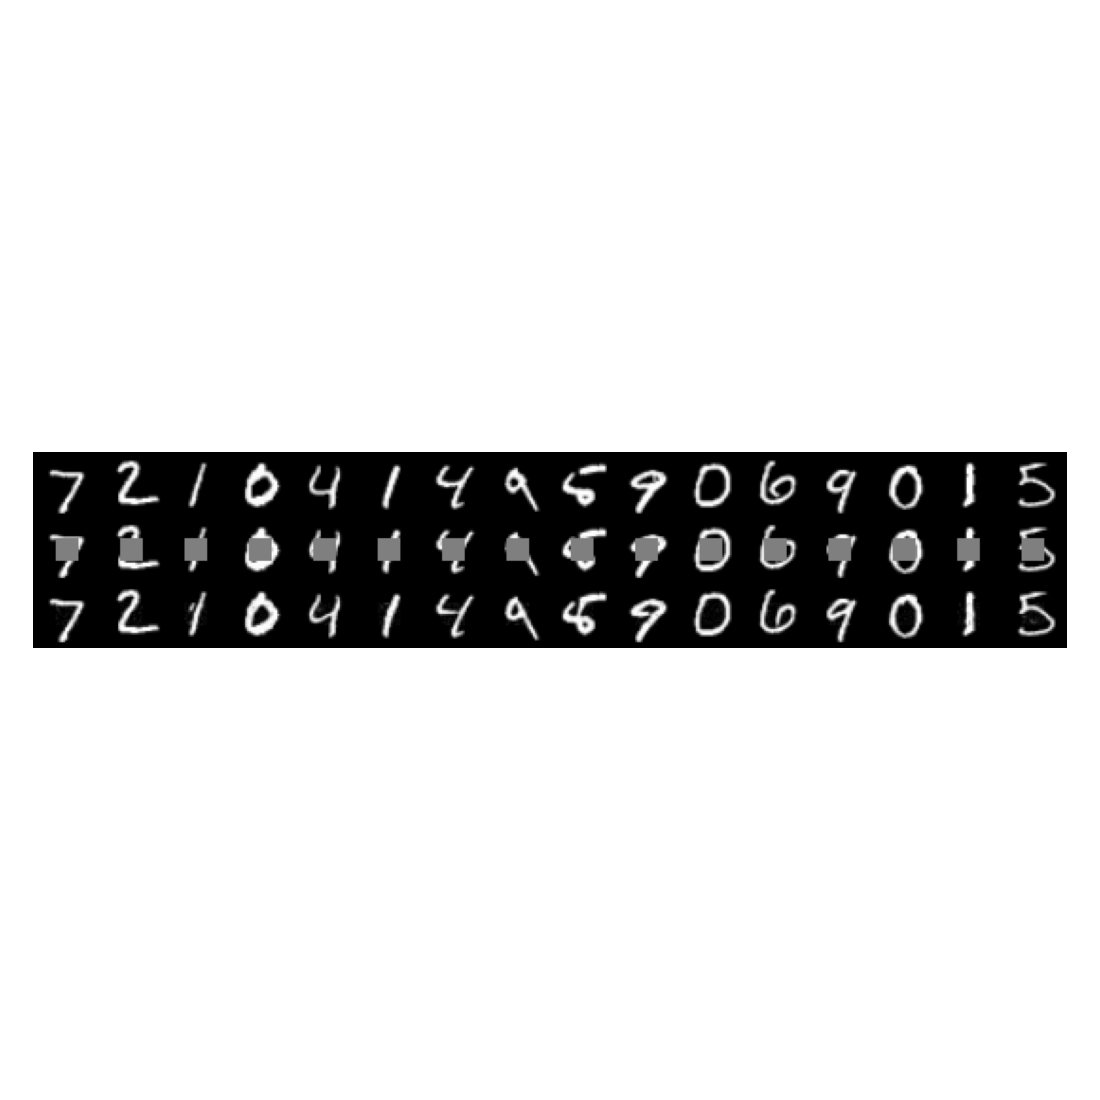

In [10]:

sample_cmd(
    ckpt="outputs/inpaint/last.pt",
    n=16,
    steps=400,
    center_box=12,
    dc_repeats=2,
    dc_fixed_z=True,
    pred="v",
    self_cond=True,
    init_from_y=True,
    eta=0.0,
    coord_conv=True,
)

from IPython.display import Image, display
display(Image(filename="outputs/inpaint/samples.png"))


## 11. Evaluate _(hole-only PSNR/L1)_

Runs inpainting on the MNIST **test** split up to `n_eval` images, computes **PSNR/L1 over the hole region**, and saves **`results/inpaint_metrics.json`** (also prints the values).

> For fair comparison, match `steps` and `center_box` with training; use `η=0` for deterministic DDIM.


In [11]:
eval_cmd(
    ckpt="outputs/inpaint/last.pt",
    batch_size=256,
    n_eval=500,
    steps=50,
    center_box=12,
    dc_repeats=2,
    dc_fixed_z=True,
    pred="v",
    self_cond=True,
    init_from_y=True,
    eta=0.0,
    coord_conv=True,
    seed=123,
)


{
  "psnr_hole": 14.548251152038574,
  "l1_hole": 0.20174670964479446
}
